# Preprocess the reference processed and filtered by CATLAS

In [2]:
import os
import scanpy as sc
import sctoolbox.plotting as pl
import sctoolbox.tools as tools
import sctoolbox.utils as utils

import matplotlib.pyplot as plt

In [3]:
reference_h5ad = 'heart_atrial_appendage_SM-IOBHN.h5ad'
reference_path = '/mnt/workspace2/jdetlef/peakqc_paperprep/benchmarking/data/reference_data'
reference_h5ad = os.path.join(reference_path, reference_h5ad)

In [4]:
adata = sc.read_h5ad(reference_h5ad)

### 1. - Select highly variable features

/home/jdetlef/.conda/envs/pqc-sctoolbox/lib/python3.11/site-packages/sctoolbox/tools/highly_variable.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  n_cells = n_cells[idx_selection]


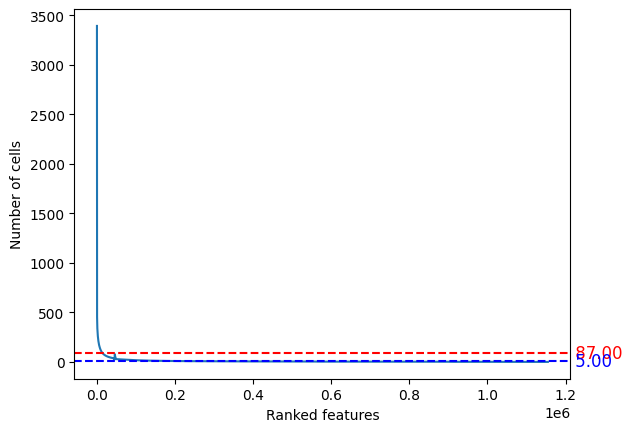

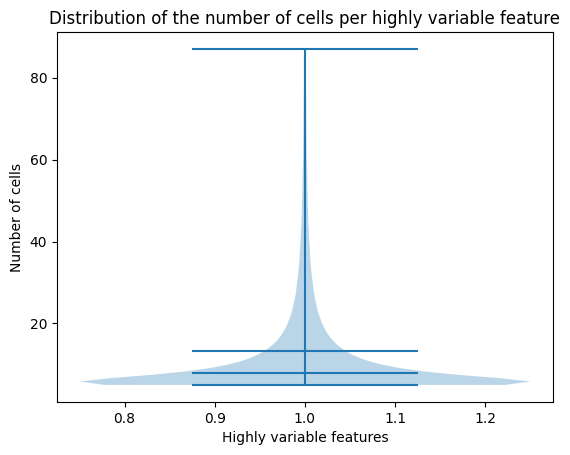

In [5]:
min_cells = 5 # This one is mandatory
max_cells = None

# update number of cells per feature
adata = tools.qc_filter.calculate_qc_metrics(adata, var_type='features')

# drop total_counts as it is the same as n_features
adata.obs.drop(columns=["total_counts", "log1p_total_counts"], inplace=True)

# get highly variable features
tools.highly_variable.get_variable_features(adata, max_cells, min_cells)
#Number of variable genes selected
adata.var["highly_variable"].sum()
# plot HVF violin
pl.highly_variable.violin_HVF_distribution(adata) 

In [6]:
## Normalize

In [7]:
threads=4

# Choose normalization method
# TF-IDF: dimensionality is reduced by LSI
# Total: dimensionality is reduced by PCA 
norm_method = 'tfidf'  # can be 'tfidf' or 'total'

# Choose if highly variable features should be used
use_highly_variable = True

# Set number of neighbors
n_neighbors = 15

# UMAP related settings 
metacol = 'tissue'  # some meta-column of interest. See tables above.
condition_column='tissue'
n_features = 'n_features'  # column name for the number of features. See tables above.

# number of PCs shown within the heatmap
n_pcs_heatmap = 30

# Whether PCs should be filtered
subset_pcs = True

corr_thresh = 0.7  # PCs with an absolut correlation above this will be filtered
perc_thresh = 30 # Top percentile of PCs that should be kept
filter_methods = ['cumulative variance', 'correlation']  # propose PCs based on the provided methods
basis = 'obs'  # base correlation on obs or var
ignore_cols = []  # List of column names to ignore for correlation

embedding='umap'

n_components = 2  # Number of components for umap (>=3 enables 3d UMAP but likely degrades 2d results)

dist_range = (0.1, 0.31, 0.1)  # Set min_dist range for umap
spread_range = (1, 3.1, 0.5)  # Set spread range for umap

perplexity_range = (30, 60, 10)  # perplexity range for tsne
learning_rate_range = (400, 1000, 200)  # learning_rate for tsne

# Search different clustering resolutions
search_clustering_parameters = True
cluster_res_range = (0.1, 1, 0.1)  # Set the searched resolution range from low to high resolution (less to more clusters).
clustering_method = "leiden"  # leiden or louvain
cluster_ncols = 3  # Number of columns displayed in the plot

In [8]:
# Save raw layer before normalization
adata.layers["raw"] = adata.X.copy()

adata = tools.norm_correct.normalize_adata(adata, norm_method, use_highly_variable=use_highly_variable)

[INFO] Performing TFIDF and LSI...


/home/jdetlef/.conda/envs/pqc-sctoolbox/lib/python3.11/site-packages/sctoolbox/tools/norm_correct.py:210: RuntimeWarning: divide by zero encountered in divide
  idf = np.asarray(adata.shape[0] / matrix.sum(axis=0)).reshape(-1)


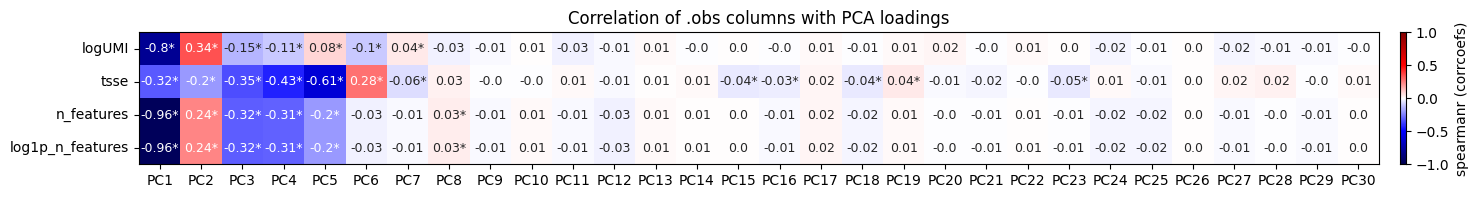

In [9]:
 # PCA correlations with obs variables 
_ = pl.embedding.plot_pca_correlation(
    adata,
    n_components=n_pcs_heatmap,
    which="obs",
    title="Correlation of .obs columns with PCA loadings",
    save="PCA_correlation_obs.pdf"
)
plt.show()

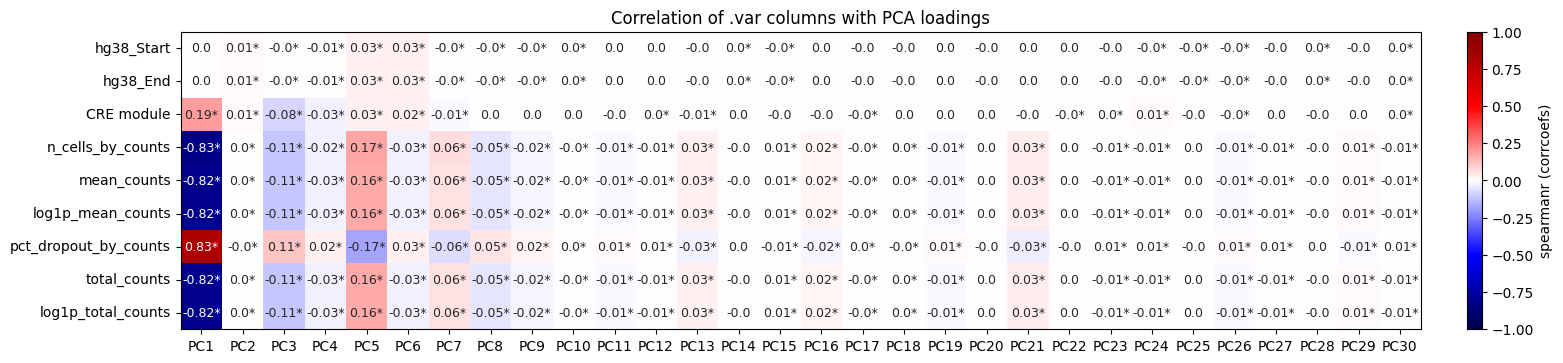

In [10]:
 # PCA correlations with var variables
_ = pl.embedding.plot_pca_correlation(
    adata,
    n_components=n_pcs_heatmap,
    which="var",
    title="Correlation of .var columns with PCA loadings",
    save="PCA_correlation_var.pdf"
)
plt.show()

In [11]:
selected_pcs = tools.dim_reduction.propose_pcs(
    anndata=adata,
    how=filter_methods,
    corr_thresh=corr_thresh,
    perc_thresh=perc_thresh,
    corr_kwargs={'method': 'spearmanr', 'which': basis, 'ignore': ignore_cols}
)

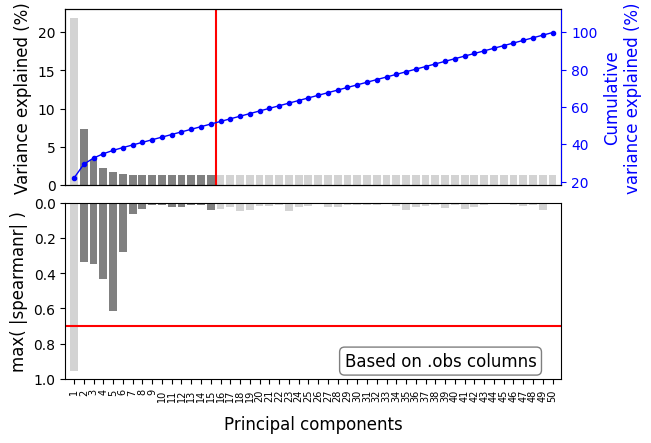

In [12]:
# Plot and select number of PCs
_ = pl.embedding.plot_pca_variance(
    adata, 
    save='PCA_variance_proposed_selection.pdf',
    selected=selected_pcs,
    n_pcs=50,
    n_thresh=max(selected_pcs),
    corr_plot='spearmanr',
    corr_thresh=corr_thresh,
    corr_on=basis,
    ignore=ignore_cols
)
plt.show()

In [13]:
tools.dim_reduction.subset_PCA(adata, select=selected_pcs)

In [14]:
sc.pp.neighbors(adata, n_neighbors=n_neighbors, method='umap', metric='euclidean')

Computing UMAPs:   0%|          | 0/15 [00:00<?, ?it/s]

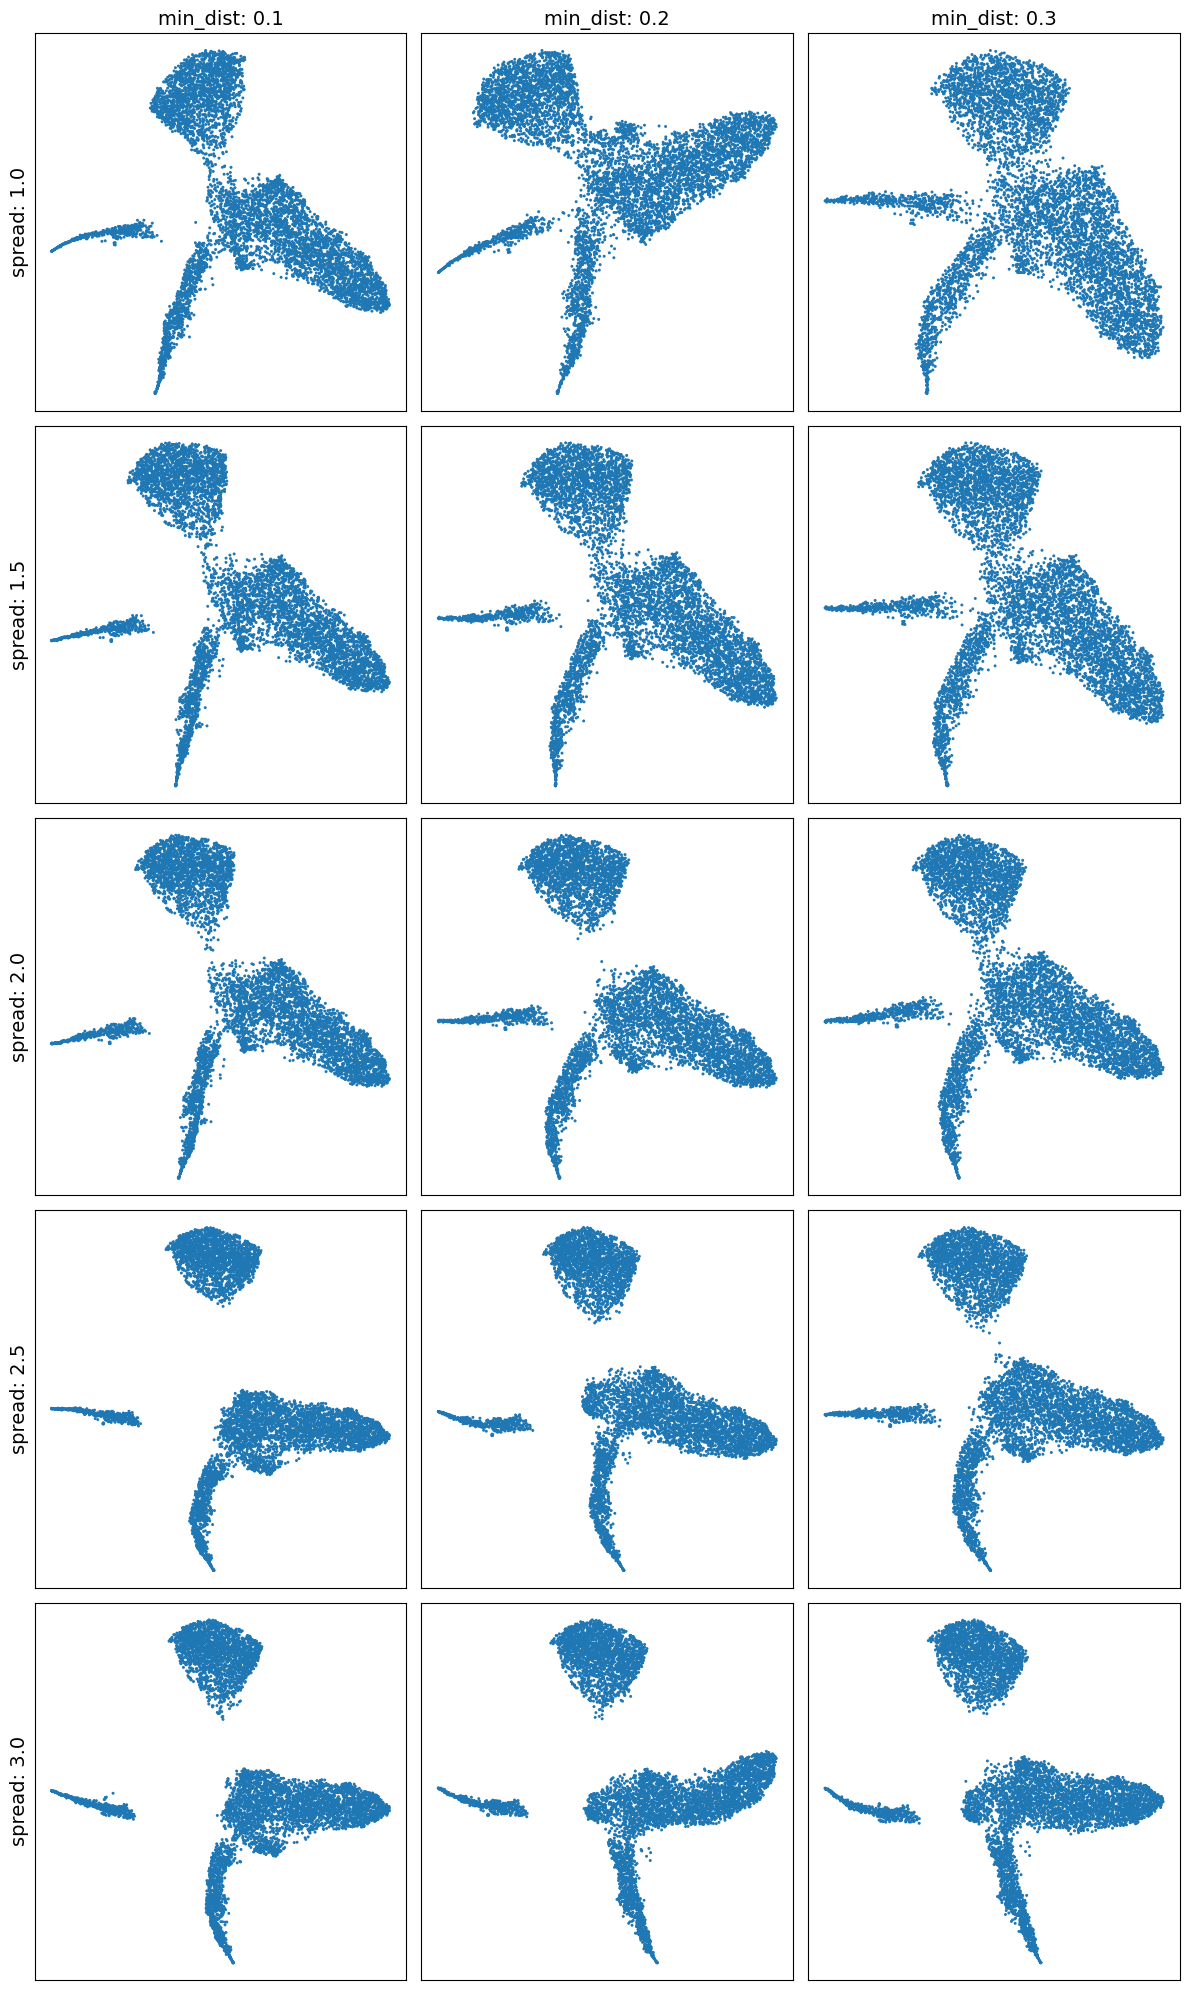

In [15]:
if embedding == "umap":
    pl.embedding.search_umap_parameters(
        adata, 
        min_dist_range=dist_range,
        spread_range=spread_range,
        color=condition_column,
        n_components=n_components,
        threads=threads,
        save="UMAP_parameter_search.pdf"
    )
elif embedding == "tsne":
    pl.embedding.search_tsne_parameters(
        adata, 
        perplexity_range=perplexity_range,
        learning_rate_range=learning_rate_range,
        color=condition_column,
        threads=threads,
        save="TSNE_parameter_search.pdf"
    )
plt.show()

In [16]:
sc.tl.umap(adata, min_dist=0.3, spread=2.0, n_components=n_components)

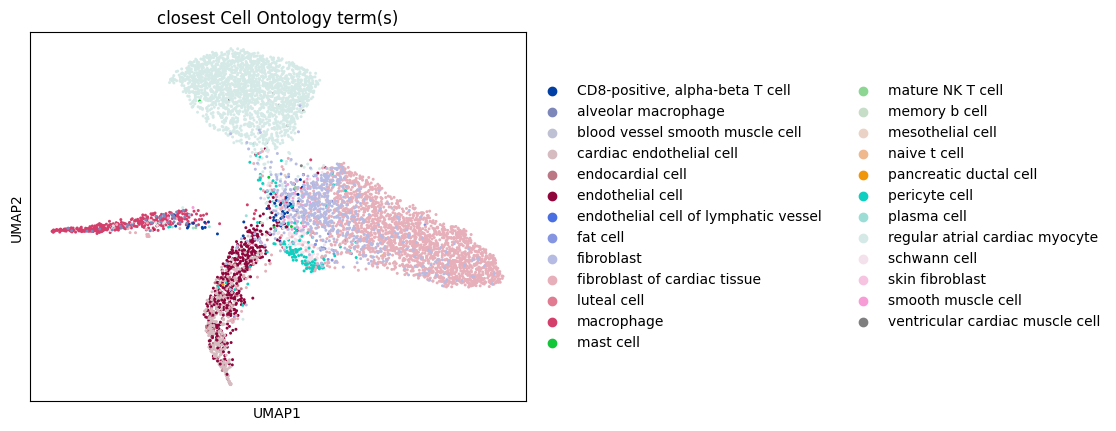

In [19]:
sc.pl.umap(adata, color='closest Cell Ontology term(s)')

In [18]:
adata.obs

,logUMI,tsse,tissue,cell type,Life stage,closest Cell Ontology term(s),Cell Ontology ID,n_features,log1p_n_features
index,,,,,,,,,
heart_atrial_appendage_SM-IOBHN_1+TGGTGCGCATTGGCTTCTACCA,3.226084,17.182817,heart_atrial_appendage_SM-IOBHN,Naive T cell,Adult,naive t cell,CL:0000898,1107,7.010312
heart_atrial_appendage_SM-IOBHN_1+TGTCCAGTCGCAGTTGACGCTC,3.204934,26.704545,heart_atrial_appendage_SM-IOBHN,Naive T cell,Adult,naive t cell,CL:0000898,1198,7.089243
heart_atrial_appendage_SM-IOBHN_1+CTACAATTCGACTCTTCCTCAT,3.054613,17.355372,heart_atrial_appendage_SM-IOBHN,Alveolar Capillary Endothelial Cell,Adult,endothelial cell,CL:0000115,562,6.333280
heart_atrial_appendage_SM-IOBHN_1+ATACCTGGAGTCGCGAGATAGT,3.022016,16.433566,heart_atrial_appendage_SM-IOBHN,Endothelial (Exocrine Tissues),Adult,endothelial cell,CL:0000115,660,6.493754
heart_atrial_appendage_SM-IOBHN_1+GGATTGCCTTGACTTACTGCCG,3.093071,17.832168,heart_atrial_appendage_SM-IOBHN,Endothelial (Exocrine Tissues),Adult,endothelial cell,CL:0000115,739,6.606650
...,...,...,...,...,...,...,...,...,...
heart_atrial_appendage_SM-IOBHN_1+CTCATAGTGGAGTCCTGGTACT,3.621280,9.625668,heart_atrial_appendage_SM-IOBHN,Pericyte (General) 2,Adult,pericyte cell,CL:0000669,1976,7.589336
heart_atrial_appendage_SM-IOBHN_1+AGCATGGAGAGAGTGGTTGACC,3.013680,19.617225,heart_atrial_appendage_SM-IOBHN,Endothelial Cell (General) 3,Adult,endothelial cell,CL:0000115,659,6.492240
heart_atrial_appendage_SM-IOBHN_1+CTACAATTCGACAGATCAACGC,3.055378,18.181818,heart_atrial_appendage_SM-IOBHN,Endothelial Cell (General) 3,Adult,endothelial cell,CL:0000115,716,6.575076


adata.obs

In [32]:
utils.adata.save_h5ad(adata, 'CATLAS_IOBHN.h5ad')

[INFO] The adata object was saved to: CATLAS_IOBHN.h5ad
